<font size=6 >**EE4211 Data Science for IoT**</font>

- **Team Name: *Big Three***
- **Team Member: *Gu Jiapan(A0186538N), Xin Yuhui(A0186542Y), Wang An(A0186543X)***

In this project, we will consider natural gas consumption data from residential consumers. The smart gas meter data used for this paper was obtained from the Pecan Street project (https://www.pecanstreet.org/). The source of the data are homes in the Mueller neighborhood of Austin, Texas, USA. In the following scripts, we will do some analysis on the data.

<font size=4 >**Part 1: Interim**</font>

**1.** Firstly, we import some libraries and have a glimpse at the raw data.

In [1]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
from sklearn.metrics import mean_squared_error as mse
from sklearn.svm import SVR
# %matplotlib inline

In [2]:
# Import raw data
df = pandas.read_csv('dataport-export_gas_oct2015-mar2016.csv',\
                     nrows=2000000)
print('Dimension of dataset: ', df.shape)
print('Glimpse of dataset: \n', df)

Dimension of dataset:  (1584823, 3)
Glimpse of dataset: 
                            localminute  dataid  meter_value
0               2015-10-01 00:00:10-05     739        88858
1               2015-10-01 00:00:13-05    8890       197164
2               2015-10-01 00:00:20-05    6910       179118
3               2015-10-01 00:00:22-05    3635       151318
4               2015-10-01 00:00:22-05    1507       390354
5               2015-10-01 00:00:29-05    5810        97506
6               2015-10-01 00:01:00-05     484        99298
7               2015-10-01 00:01:18-05    6910       179118
8               2015-10-01 00:01:34-05    6910       179118
9               2015-10-01 00:01:38-05    5810        97506
10              2015-10-01 00:01:43-05    4352       218216
11              2015-10-01 00:01:46-05     484        99298
12              2015-10-01 00:01:56-05    1718       161076
13              2015-10-01 00:01:58-05    1714       147048
14              2015-10-01 00:02:15-05    

*We can see that*

(1) The data has the following format: **Timestamp (localtime) MeterID (dataid) meter reading (meter_value).** 

(2) There are overall **1584823** pieces of data.

**2.** Derive total number of houses included in the dataset by counting the number of different dataid.

In [3]:
home=pandas.DataFrame.drop_duplicates(df,subset='dataid',\
                                      keep='first',\
                                      inplace=False)
print('Total number of houses included in the dataset:',\
                                      home.shape[0])
print('The 1st timestamp and readings of every house:\n',home)

Total number of houses included in the dataset: 157
The 1st timestamp and readings of every house:
                            localminute  dataid  meter_value
0               2015-10-01 00:00:10-05     739        88858
1               2015-10-01 00:00:13-05    8890       197164
2               2015-10-01 00:00:20-05    6910       179118
3               2015-10-01 00:00:22-05    3635       151318
4               2015-10-01 00:00:22-05    1507       390354
5               2015-10-01 00:00:29-05    5810        97506
6               2015-10-01 00:01:00-05     484        99298
10              2015-10-01 00:01:43-05    4352       218216
12              2015-10-01 00:01:56-05    1718       161076
13              2015-10-01 00:01:58-05    1714       147048
14              2015-10-01 00:02:15-05    9849        33632
15              2015-10-01 00:02:16-05    5131       104132
16              2015-10-01 00:02:18-05    6412       133016
17              2015-10-01 00:02:20-05    7429       132644


**3.** By overviewing the dataset, there are some irregular or weird meter readings which may relate to the malfunctioning of meters in the six months. From our point of view, there are 3 possible malfunction conditions based on the dataset.

1. After having a overview of the dataset, we find that there are cases when the meter readings are the same with the time changing. And all the first meter readings of 157 houses are not zreo. This means that even there is no gas comsumption for a relatively long time, the meter also reports a reading. Besides, all these meters are not newly added. Based on these assumptions, every meter for the 157 houses should start reporting readings from October 1st, 2015. However, according to the timestamp and meter readings for every house, we find that not all first readings are on 2015-10-01. So this is the first kind of malfunctioning condition.

2. Normally every family has a relatively stable habit of consuming gas. Thus a fully-functioning gas meter should have similar times of reporting readings every month. If for a specific month, the sum readings of one house is obviously fewer than normal, then we should conclude that there are sometime when the meter is malfunctioning during that month.

3. The gas meters measure the cumulative gas consumption, so cases when the meter readings decrease as time goes by should be considered problematic.

- 1) *First kind of malfunctioning:* For each dataid(related to corresponding meter), the malfunctioning period is from 1st of October to the first time when there is a reading.

In [4]:
#Print out time and dataid when abnormal readings appear.
pandas.set_option('display.max_rows', None)
for i in range(home.shape[0]):
    if int(home.localminute.iloc[i].split('-')[2].split(' ')[0])!=1:
        break;
print('The first kind of malfunctioning meters are shown as below:\n')
print(home.iloc[i:-1,:])

The first kind of malfunctioning meters are shown as below:

                          localminute  dataid  meter_value
11436          2015-10-02 08:54:27-05    4193       289668
18211          2015-10-03 03:48:54-05    8703       210416
18597          2015-10-03 04:51:53-05    6578       157806
35710          2015-10-05 02:44:01-05    4228        85162
47472          2015-10-06 11:52:20-05    2645        59318
63854          2015-10-08 10:01:28-05    6505       132928
63993          2015-10-08 10:22:34-05    5395       136658
66974          2015-10-08 18:13:29-05    8059       101626
82535          2015-10-10 11:54:39-05    7965       174608
101655         2015-10-12 18:33:44-05      44       165674
109298         2015-10-13 14:50:40-05    4671        89976
170248         2015-10-20 09:16:24-05    6685        95064
218087         2015-10-27 00:02:57-05    7989       110614
218091         2015-10-27 00:03:24-05    2945       144018
218106         2015-10-27 00:06:11-05    2818       16

- 2) *Second kind of malfunctioning:* For a specific dataid(meter), when the sum readings of one month is especially fewer than normal case, there should be something wrong in that month.

In [5]:
# Count the numbers of readings for each meter in each month
k=0
for j in home.dataid:
    record=df[df.dataid==j]
    num=record.shape[0]
    print('Dataid:',j,': number of record:',num)
    st = [0 for col in range(6)]
    for i in range(num):
        temp = record.localminute.iloc[i].split('-')
        if int(temp[1])==10:
            st[0]=st[0]+1
        if int(temp[1])==11:
            st[1]=st[1]+1
        if int(temp[1])==12:
            st[2]=st[2]+1
        if int(temp[1])==1:
            st[3]=st[3]+1
        if int(temp[1])==2:
            st[4]=st[4]+1
        if int(temp[1])==3:
            st[5]=st[5]+1
    print(st,'\n')
    k=k+1
    
    if k>=20:
        break
print("... ...")

Dataid: 739 : number of record: 31430
[5530, 5132, 5209, 4808, 4945, 5806] 

Dataid: 8890 : number of record: 16574
[3412, 3004, 3059, 2862, 2918, 1319] 

Dataid: 6910 : number of record: 69349
[12403, 11666, 11645, 12850, 10934, 9851] 

Dataid: 3635 : number of record: 9186
[1351, 1462, 1425, 1799, 1457, 1692] 

Dataid: 1507 : number of record: 32603
[7292, 7098, 4619, 5828, 2971, 4795] 

Dataid: 5810 : number of record: 42234
[7578, 7366, 7209, 6192, 6404, 7485] 

Dataid: 484 : number of record: 44034
[7475, 7547, 6904, 7348, 7121, 7639] 

Dataid: 4352 : number of record: 3304
[1588, 958, 471, 0, 212, 75] 

Dataid: 1718 : number of record: 24470
[3988, 3992, 3939, 4177, 4007, 4367] 

Dataid: 1714 : number of record: 32933
[6424, 5341, 5538, 5346, 4840, 5444] 

Dataid: 9849 : number of record: 2741
[913, 487, 547, 250, 280, 264] 

Dataid: 5131 : number of record: 15187
[2768, 2402, 2395, 2735, 2696, 2191] 

Dataid: 6412 : number of record: 15783
[3975, 1749, 1949, 2667, 3090, 2353] 



Due to the large amount of data, to prevent the length of the report from being too long, we only show part of the results here.

According to the results above, we can choose any meter to analyze. If we find that there is one month which the number is quite small, we can assume that there is malfunctioning during that month for that meter. Then we can target on that month and do further analysis. For example, for the meter whose id is 739, every number of the six month is around 5000. This means that perhaps this meter wasn't malfunction in this period. However, for the meter 1507, the number is only about 3000 for Febrary of 2016, which is much smaller than the other months. Under this kind of condition, we could judge that this meter is malfunction in sometime of Febrary of 2016.

- 3) *Third kind of malfunctioning:* Meter readings decrease. Take October of 2015 as an example.

In [6]:
df_O=pandas.read_csv('dataport-export_gas_oct2015-mar2016.csv',\
                     nrows=266449)
home_O=pandas.DataFrame.drop_duplicates(df_O,subset='dataid',\
                                        keep='first',\
                                        inplace=False)

In [7]:
# Consider every meter, search for the cases when reading decreases. 
# Print maifuntioning meter id and timestamp.
k=1
for j in home_O.dataid:
    record=df_O[df_O.dataid==j]
    num=record.shape[0]
    new = [[0 for col in range(num)] for row in range(2)]
    for i in range(num):
        temp = record.localminute.iloc[i].split(' ')
        temp1 = temp[0]
        temp2 = temp[1].split('-')[0]
        t = 0
        temp = temp2.split(':')
        t = t+int(temp[2])+int(temp[1])*60+int(temp[0])*60*60
        temp = temp1.split('-')
        t = t+(int(temp[2])-1)*24*60*60
        new[0][i] = t
        new[1][i] = int(record.meter_value.iloc[i])-\
                    int(record.meter_value.iloc[0])
        if i>=1:
            if int(record.meter_value.iloc[i])<\
               int(record.meter_value.iloc[i-1]):
                print('Dataid:',j,'   time:',record.localminute.iloc[i])
    
    k=k+1

Dataid: 8890    time: 2015-10-01 19:07:10-05
Dataid: 8890    time: 2015-10-02 05:12:56-05
Dataid: 8890    time: 2015-10-02 17:51:56-05
Dataid: 8890    time: 2015-10-02 18:08:48-05
Dataid: 8890    time: 2015-10-02 22:34:48-05
Dataid: 8890    time: 2015-10-03 17:10:06-05
Dataid: 8890    time: 2015-10-04 00:24:52-05
Dataid: 8890    time: 2015-10-04 09:28:03-05
Dataid: 8890    time: 2015-10-04 14:11:06-05
Dataid: 8890    time: 2015-10-05 11:09:08-05
Dataid: 8890    time: 2015-10-05 16:13:04-05
Dataid: 8890    time: 2015-10-08 15:51:04-05
Dataid: 8890    time: 2015-10-09 03:17:11-05
Dataid: 8890    time: 2015-10-09 13:41:00-05
Dataid: 8890    time: 2015-10-09 18:18:55-05
Dataid: 8890    time: 2015-10-09 19:16:03-05
Dataid: 8890    time: 2015-10-10 03:41:04-05
Dataid: 8890    time: 2015-10-10 07:14:54-05
Dataid: 8890    time: 2015-10-11 09:16:02-05
Dataid: 8890    time: 2015-10-11 18:58:10-05
Dataid: 8890    time: 2015-10-15 14:54:20-05
Dataid: 8890    time: 2015-10-15 18:47:17-05
Dataid: 88

The above resuls show each malfunctioning meter's id and timestamp(s) in October of 2015. For example, the meter with id 8890 had several malfuntioning time like 2015-10-01 19:07:10-05, 2015-10-02 05:12:56-05 and so on.

**4.**  Subtract original value for every piece of data to make 0 the start number. Then generate hourly readings from the raw data by set them as the readings before the specific hourly time point. Here we select *October* as the target month and plot the hourly readings for every house. The horizontal axis represents hours series while the vertical axis represents the generated readings. Note that:

1. For a certain hours when there is no reading, the strategy is also applicative because we are just focus on the tendency of the gas consumption, the accurate readings are not statistically significant and also unavailable according to the dataset. 

2. For the faulty meters' readings, as to the first kind of incorrect value, we just set them as zero until correct values appear. And as to the second and third kind of malfunctioning condition, generating hourly readings actually have reduced the impact of those occasional faults. Thereby, the following processing will not be significantly affected.

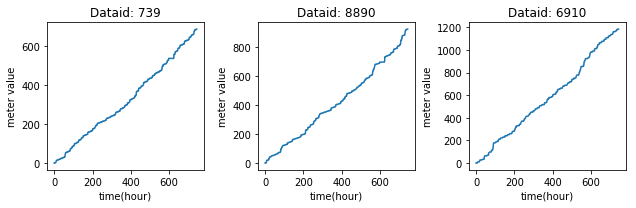

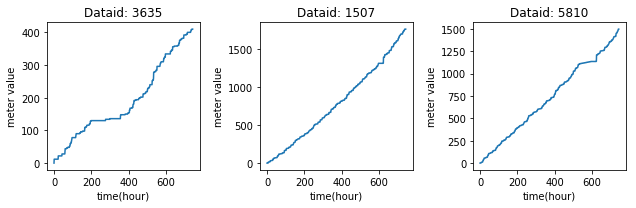

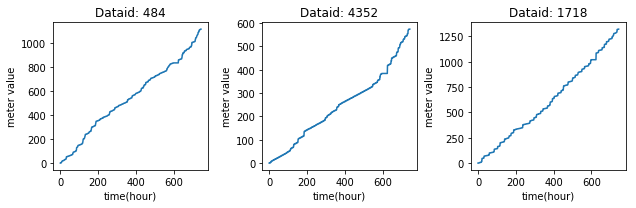

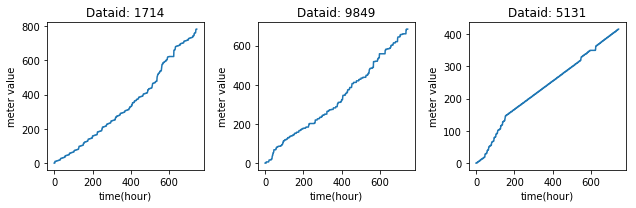

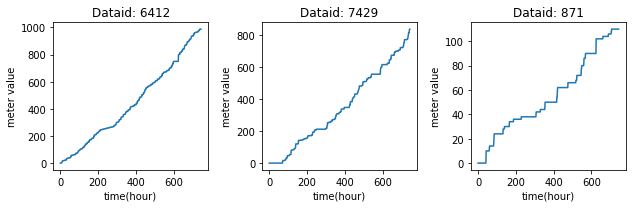

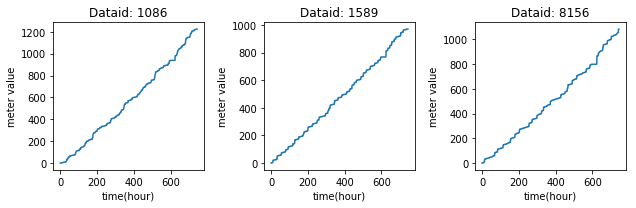

In [8]:
# Generate hourly readings and plot
k=1
hourly = [[0 for col in range(745)] for row in range(home_O.shape[0]+1)]
hourly[0] = np.arange(0,745,1)
for j in home_O.dataid:
    record=df_O[df_O.dataid==j]
    num=record.shape[0]
    new = [[0 for col in range(num)] for row in range(2)]
    for i in range(num):
        temp = record.localminute.iloc[i].split(' ')
        temp1 = temp[0]
        temp2 = temp[1].split('-')[0]
        t = 0
        temp = temp2.split(':')
        t = t+int(temp[2])+int(temp[1])*60+int(temp[0])*60*60
        temp = temp1.split('-')
        t = t+(int(temp[2])-1)*24*60*60
        new[0][i] = t
        new[1][i] = int(record.meter_value.iloc[i])-\
                    int(record.meter_value.iloc[0])
    for i in range(num-1):
        if new[0][i+1]//3600!=new[0][i]//3600:
            hourly[k][new[0][i+1]//3600] = new[1][i]
    for i in range(744):
        if hourly[k][i+1]==0:
            hourly[k][i+1]=hourly[k][i]
    k=k+1
k=k-1

ii=0
for i in range(k):
    if i%3==0:
        ii=ii+1
        plt.figure(ii,figsize=(9,3))
        plt.subplot(131)
    elif i%3==1:
        plt.subplot(132)
    else:
        plt.subplot(133)    
    plt.title('Dataid: %s'%home_O.dataid.iloc[i])
    plt.xlabel('time(hour)')
    plt.ylabel('meter value')
    plt.tight_layout()
    plt.plot(hourly[0],hourly[i+1])
    
    if i+1>=18:
        break

Due to the large amount of data, to prevent the length of the report from being too long, we only show part of the results here.

**5.** Correlation Analysis

- The term "correlation" refers to a mutual relationship or association between quantities. Correlation can help in predicting one quantity from another. Considering correlation coefficient, 1 means that two quantities are highly correlated and 0 means no correlation.

- In our project, intuitively, gas consumption from different homes should be correlated. For example, many homes would experience higher consumption levels during meal time. High correlation possibly means two houses share similar habit of gas consumption.

In [9]:
# Calculate correlation
cor = [[0 for col in range(k)] for row in range(k)]
for i in range(k):
    for j in range(k):
        if i==j:
            continue
        cor[i][j] = np.corrcoef(hourly[i+1],hourly[j+1])[0,1]
        
# Select highest 5 houses for each and print out
for i in range(k):
    print('Dataid: ',home_O.dataid.iloc[i])
    temp = cor[i]
    for j in range(5):
        max_cor = temp[0]
        max_ii = 0
        for ii in range(k):
            if ii==i:
                continue
            if temp[ii]>max_cor:
                max_cor = cor[i][ii]
                max_ii = ii
        if pandas.isnull(max_cor):
            print('None',end='')
            break
        print(home_O.dataid.iloc[max_ii],':',round(max_cor,4),' ',end='')
        temp[max_ii]=0
    print('\n')
    
    if i+1>=20:
        break
print("... ...")

D:\install\anaconda3\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\install\anaconda3\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Dataid:  739
1718 : 0.9991  1185 : 0.999  9729 : 0.9988  5439 : 0.9988  6836 : 0.9987  

Dataid:  8890
3527 : 0.9987  9729 : 0.9985  1507 : 0.9984  4031 : 0.9981  2638 : 0.9981  

Dataid:  6910
744 : 0.9986  6830 : 0.9986  94 : 0.9984  2638 : 0.9983  8890 : 0.998  

Dataid:  3635
9278 : 0.9939  871 : 0.9922  3039 : 0.9922  4732 : 0.9914  2335 : 0.9902  

Dataid:  1507
6836 : 0.9995  7674 : 0.9993  5439 : 0.9993  9729 : 0.9993  4031 : 0.9992  

Dataid:  5810
5484 : 0.9984  1790 : 0.9984  7287 : 0.9984  4514 : 0.9983  7682 : 0.9983  

Dataid:  484
1556 : 0.9975  9295 : 0.9975  2018 : 0.9972  7030 : 0.9971  7739 : 0.9966  

Dataid:  4352
1283 : 0.9975  5814 : 0.9975  2461 : 0.997  3723 : 0.9956  114 : 0.9954  

Dataid:  1718
6836 : 0.9992  5439 : 0.9992  739 : 0.9991  1185 : 0.9991  7674 : 0.9991  

Dataid:  1714
9631 : 0.9967  4732 : 0.9966  5129 : 0.9965  6910 : 0.9961  1801 : 0.996  

Dataid:  9849
739 : 0.9983  1718 : 0.998  35 : 0.9978  2233 : 0.9978  9631 : 0.9978  

Dataid:  5131
7

Due to the large amount of data, to prevent the length of the report from being too long, we only show part of the results here.

The above results show top five correlated homes and the correlations for each home.

**6.** Proposal overview

- To analyze the data further, we have the following proposal: 

- Normally, for a familly, the gas usage hourly or for a certain period of one day is relatively steady. Therefore, if hourly gas usage is significantly larger than the historical value, there might be something unusual or even unexpected happening in the house. For example, if people forget to turn off the gas which has been unused for a long time, the meter's reading would increase continuously. This causes waste of resources and even safety risks. With these concerns, we propose to build a gas usage alarming system which could generate hourly threshold value base on past data, and the threshold is adjustable rather than constant, meaning that this threshold is able to updata after a period of time. When the meter reading is higher than the threshold, the alarm would be sent to the house to avoid waste or even danger.

<font size=4 >**Part 2: Forecasting**</font>

In this part, based on the generated hourly readings before, we focus on building machine lerning models to forecast future hourly readings. Specifically, we build two ML models: linear regression model and support vector regression model. SVR model includes two kinds of kernal: linear kernal and rbf kernal.

**1.** Originally, the gas consumption dataset is messy and huge. After generating hourly values, we derive a time series dataset which looks neat and organized. Before everything starts, we should figure out the reason and value of doing this work.

Natural gas is a widely used energy source in industrial, commercial and residential sectors. Estimation and forecasting of residential natural gas consumption has drawn significant attention from the standpoints of both the residents and the supplier.  

- **For natural gas suppliers:** While other conventional energy sources, such as oil or coal, have relatively lower transportation costs, in most cases, natural gas transportation requires higher initial investments. As a result, local and international natural gas markets are historically based on long-term contracts. Given this market structure, one of the risk factors for natural gas distributors is the demand uncertainty. Therefore, accurate forecasting of the demand for natural gas is critical for an efficient management of energy resources. Based on such prediction, the supplier can adjust the supply of natural gas to each region, thus resources can be more rationally distributed. Besides, depending on whether the future consumption is increasing or decreasing, natural gas suppliers can also dynamically change the price to maximize their own benefits.

- **For natural gas consumers:** Normally, houses are accessible to several kinds of energy resources which share some common functions, such as electricity, coal, and natural gas. Therefore, based on such predictions and the price of each resource, residents can adjust their habits of consuming energy to minimize the total costs. 

- **For other related industries:** Differences in natural gas consumption between regions can suggest something for other related industries such as the catering industry. Usually majority of natural gas is used by cooking. If the gas consumption of a certain area will increase by prediction, perhaps residents are more and more inclined to cook at home. Therefore, catering investors should better choose another place to open restaurants.

In conclusion, estimation and forecasting of natural gas consumption can benefit the suppliers, the consumers and also influence other related industries. If we are able to derive a good forecasting model, all of them can be benefitted. Moreover, if we have a good forecasting model, maybe we can apply this method to other similar fields, like water consumption and electric consumption.

**2.** Building and optimizing forecasting model

Our model is based on October for training data and forecasting with November, we normalized the time start with 0, and increase hourly. October is from the 1st hour to the 744th hour, and the November is the 745th hour to the 1464th hour. So we use first 744 data to train a model. Then use the other 720 data to verify the accuracy of the model, which is comparing the predicted data with the actual data in November. At the end evaluating the pros and cons of each model by calculating mean square error.

**( 1 )**  Extract the data of October and November, then generate hourly values.

In [10]:
# Extract the data of October and November
df_two=pandas.read_csv('dataport-export_gas_oct2015-mar2016.csv',\
                     nrows=544681)
home_two=pandas.DataFrame.drop_duplicates(df_two,subset='dataid',\
                                        keep='first',\
                                        inplace=False)

# Generate hourly readings
k=0
hourly = [[0 for col in range(1465)] for row in range(home_two.shape[0]+1)]
hourly[0] = np.arange(0,1465,1)
for j in home_two.dataid:
    k=k+1
    record=df_two[df_two.dataid==j]
    num=record.shape[0]
    new = [[0 for col in range(num)] for row in range(2)]
    for i in range(num):
        temp = record.localminute.iloc[i].split(' ')
        temp1 = temp[0]
        temp2 = temp[1].split('-')[0]
        t = 0
        temp = temp2.split(':')
        t = t+int(temp[2])+int(temp[1])*60+int(temp[0])*60*60
        temp = temp1.split('-')
        t = t+(int(temp[2])-1)*24*60*60+(int(temp[1])-10)*24*60*60*31
        new[0][i] = t
        new[1][i] = int(record.meter_value.iloc[i])-\
                    int(record.meter_value.iloc[0])
    for i in range(num-1):
        if new[0][i+1]//3600!=new[0][i]//3600:
            hourly[k][new[0][i+1]//3600] = new[1][i]
    for i in range(1464):
        if hourly[k][i+1]==0:
            hourly[k][i+1]=hourly[k][i]

**( 2 )** Conventional model

Linear regression:
Dataid:  739
Mean squared error on the training data: 214.41
Mean squared error on the predicted data: 168566.94
Dataid:  8890
Mean squared error on the training data: 437.70
Mean squared error on the predicted data: 827736.63
Dataid:  6910
Mean squared error on the training data: 715.84
Mean squared error on the predicted data: 562052.00
Dataid:  3635
Mean squared error on the training data: 685.02
Mean squared error on the predicted data: 948464.41
Dataid:  1507
Mean squared error on the training data: 1551.87
Mean squared error on the predicted data: 511709.95


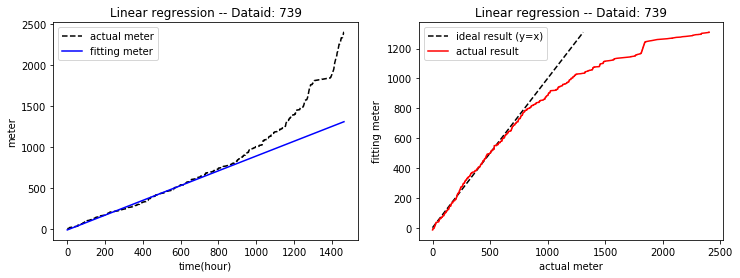

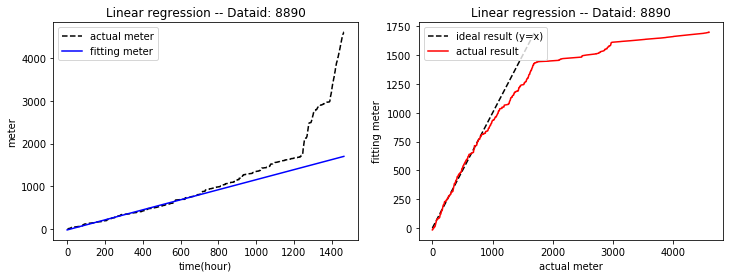

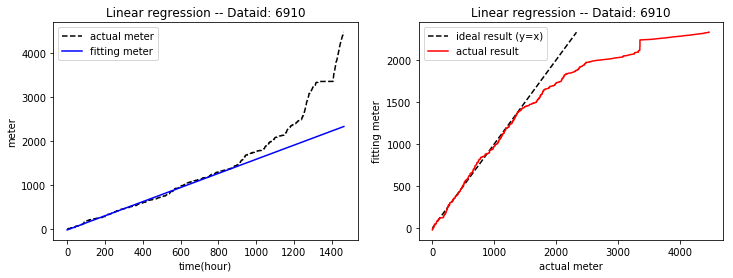

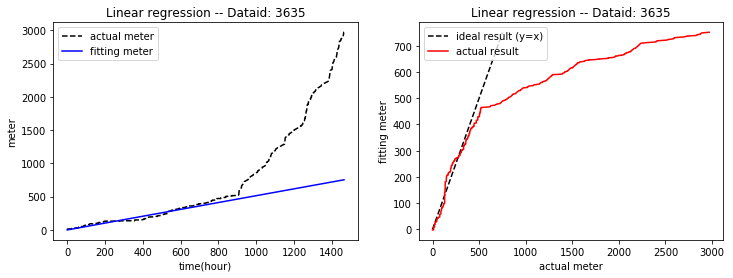

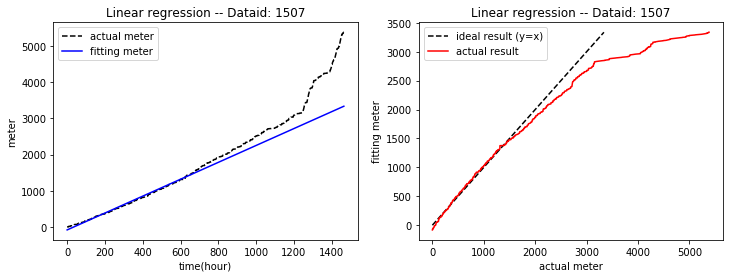

In [11]:
# Linear Regression
lr=lm.LinearRegression()
x_tr = np.arange(0,745,1)
print('Linear regression:')
for i in range(k):
    if i+1>5:
        break
    lr.fit(x_tr[:,np.newaxis],hourly[i+1][0:745])
    y_lr=lr.predict(hourly[0][:,np.newaxis])
    
    print('Dataid: ',home_two.dataid.iloc[i])
    mse_train=mse(hourly[i+1][0:745],y_lr[0:745])
    print(f'Mean squared error on the training data: {mse_train:.2f}')
    mse_prediction=mse(hourly[i+1][745:],y_lr[745:])
    print(f'Mean squared error on the predicted data: {mse_prediction:.2f}')
    
    plt.figure(i,figsize=(12,4))
    plt.subplot(121)
    plt.plot(hourly[0],hourly[i+1],'--k',label='actual meter')
    plt.plot(hourly[0],y_lr,'b',label='fitting meter')
    plt.xlabel('time(hour)')
    plt.ylabel('meter')
    plt.title('Linear regression -- Dataid: %s'%home_two.dataid.iloc[i])
    plt.legend(loc=2)
    plt.subplot(122)
    m = min(hourly[i+1][-1],y_lr[-1])
    mm = np.arange(0,m,1)
    plt.plot(mm,mm,'--k',label='ideal result (y=x)')
    plt.plot(hourly[i+1],y_lr,'r',label='actual result')
    plt.xlabel('actual meter')
    plt.ylabel('fitting meter')
    plt.title('Linear regression -- Dataid: %s'%home_two.dataid.iloc[i])
    plt.legend(loc=2)

**Analysis:**

First, we use the linear regression to build the model. The time before 745th hour is the data of October, the left pictures show that the actual data and fitting data are almost the same, the model try the best to make a straight line fit the raw data, then after the 745th is the data of November and we can see the blue line is how the model think the data should be. For all users, at the beginning the actual data matches the fitting data, but only for a short time. As time increases, the actual data becomes more and more deviated from the fitting data. In the last 200 hours the prediction model is completely unrealistic. This unrealistic phenomenon also can be seen from the right pictures.
Of course from the MSE we can see the training data is perfect fit which have a very small MSE value, but the predicted data is on the opposite which have a large MSE value.

SVR(linear):
Dataid:  739
Mean squared error on the training data: 232.66
Mean squared error on the predicted data: 178038.15
Dataid:  8890
Mean squared error on the training data: 448.60
Mean squared error on the predicted data: 845041.43
Dataid:  6910
Mean squared error on the training data: 768.91
Mean squared error on the predicted data: 535028.51
Dataid:  3635
Mean squared error on the training data: 807.03
Mean squared error on the predicted data: 918697.05
Dataid:  1507
Mean squared error on the training data: 1936.50
Mean squared error on the predicted data: 590121.83


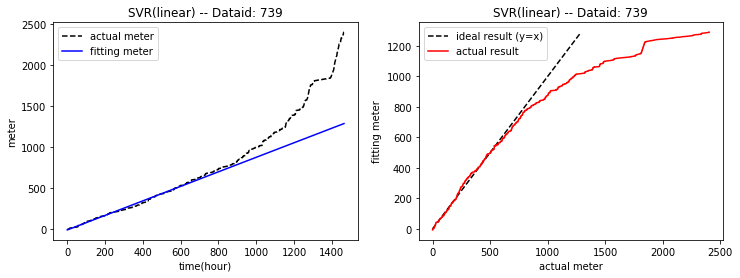

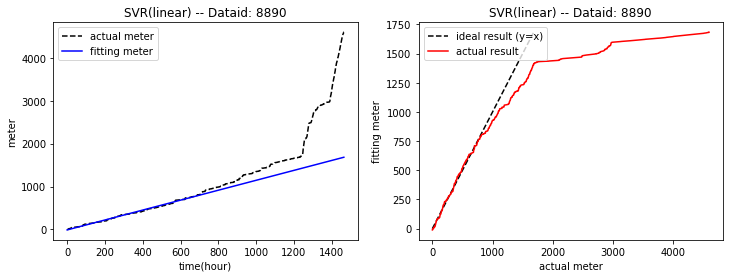

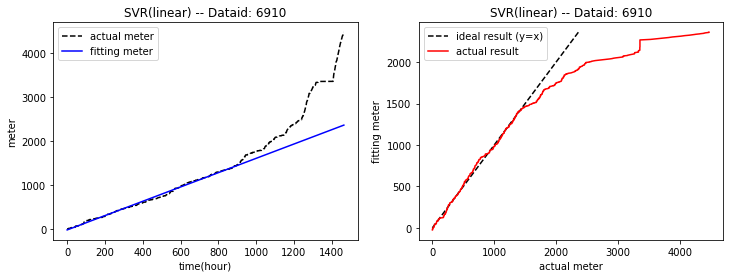

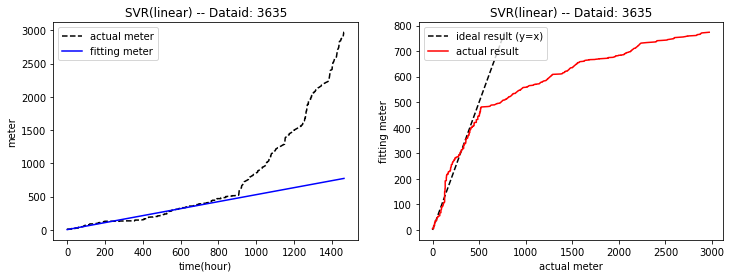

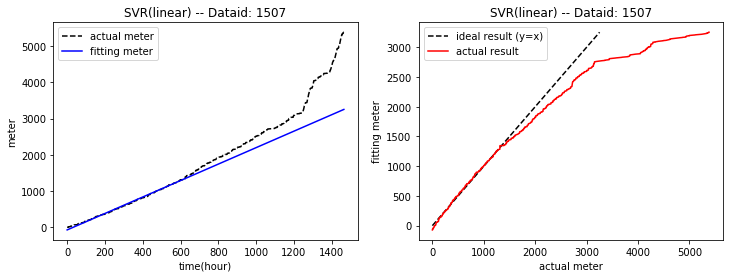

In [12]:
# SVR (linear)
lr = SVR(kernel="linear")
print('SVR(linear):')
for i in range(k):
    if i+1>5:
        break
    fit=lr.fit(x_tr[:,np.newaxis],hourly[i+1][0:745])
    y_lr=fit.predict(hourly[0][:,np.newaxis])
    
    print('Dataid: ',home_two.dataid.iloc[i])
    mse_train=mse(hourly[i+1][0:745],y_lr[0:745])
    print(f'Mean squared error on the training data: {mse_train:.2f}')
    mse_prediction=mse(hourly[i+1][745:],y_lr[745:])
    print(f'Mean squared error on the predicted data: {mse_prediction:.2f}')
    
    plt.figure(i,figsize=(12,4))
    plt.subplot(121)
    plt.plot(hourly[0],hourly[i+1],'--k',label='actual meter')
    plt.plot(hourly[0],y_lr,'b',label='fitting meter')
    plt.xlabel('time(hour)')
    plt.ylabel('meter')
    plt.title('SVR(linear) -- Dataid: %s'%home_two.dataid.iloc[i])
    plt.legend(loc=2)
    plt.subplot(122)
    m = min(hourly[i+1][-1],y_lr[-1])
    mm = np.arange(0,m,1)
    plt.plot(mm,mm,'--k',label='ideal result (y=x)')
    plt.plot(hourly[i+1],y_lr,'r',label='actual result')
    plt.xlabel('actual meter')
    plt.ylabel('fitting meter')
    plt.title('SVR(linear) -- Dataid: %s'%home_two.dataid.iloc[i])
    plt.legend(loc=2)

**Analysis:**

Then, we use the SVR (linear) to build the model. In this condition the left pictures still show that the actual data and fitting data are almost same in October, and in November, this model shows the similar situation with the linear regression model but with a little bit worse performance. 
This time the MSE of predicted data is bigger than before.

SVR(rbf):
Dataid:  739
Mean squared error on the training data: 18.03
Mean squared error on the predicted data: 1138886.46
Dataid:  8890
Mean squared error on the training data: 84.64
Mean squared error on the predicted data: 2905749.81
Dataid:  6910
Mean squared error on the training data: 355.00
Mean squared error on the predicted data: 3613455.12
Dataid:  3635
Mean squared error on the training data: 2.64
Mean squared error on the predicted data: 1796008.92
Dataid:  1507
Mean squared error on the training data: 15426.05
Mean squared error on the predicted data: 5951220.37


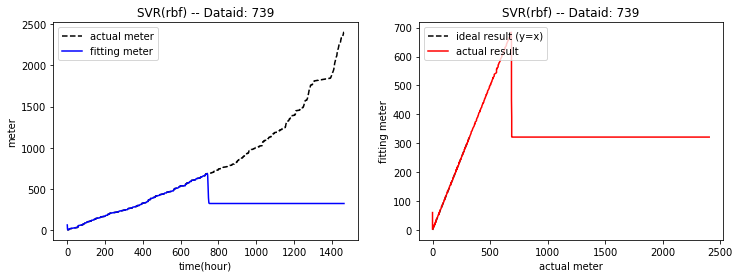

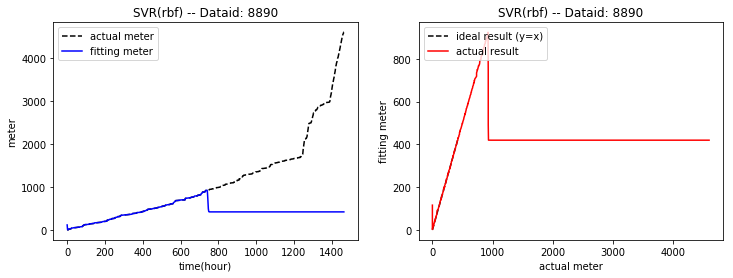

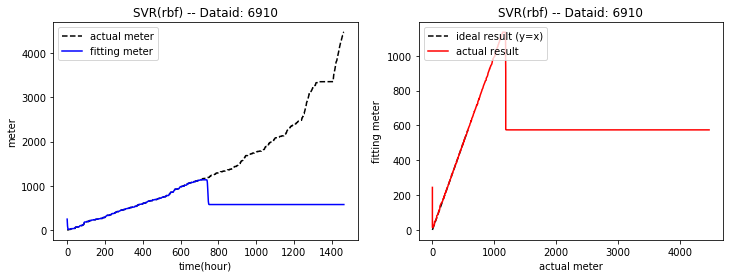

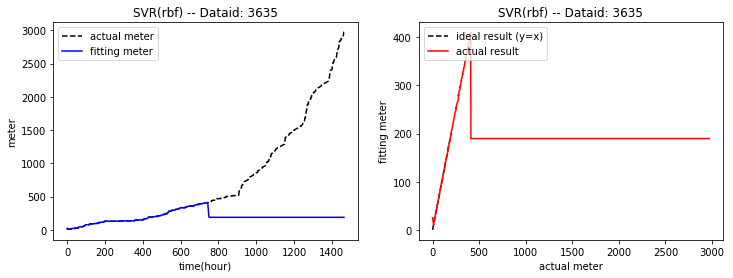

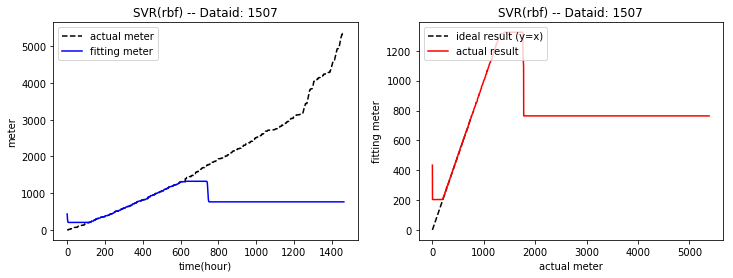

In [13]:
# SVR (rbf)
lr = SVR(kernel="rbf",C=100,gamma=0.1)
print('SVR(rbf):')
for i in range(k):
    if i+1>5:
        break
    fit=lr.fit(x_tr[:,np.newaxis],hourly[i+1][0:745])
    y_lr=fit.predict(hourly[0][:,np.newaxis])
    
    print('Dataid: ',home_two.dataid.iloc[i])
    mse_train=mse(hourly[i+1][0:745],y_lr[0:745])
    print(f'Mean squared error on the training data: {mse_train:.2f}')
    mse_prediction=mse(hourly[i+1][745:],y_lr[745:])
    print(f'Mean squared error on the predicted data: {mse_prediction:.2f}')
    
    plt.figure(i,figsize=(12,4))
    plt.subplot(121)
    plt.plot(hourly[0],hourly[i+1],'--k',label='actual meter')
    plt.plot(hourly[0],y_lr,'b',label='fitting meter')
    plt.xlabel('time(hour)')
    plt.ylabel('meter')
    plt.title('SVR(rbf) -- Dataid: %s'%home_two.dataid.iloc[i])
    plt.legend(loc=2)
    plt.subplot(122)
    m = min(hourly[i+1][-1],y_lr[-1])
    mm = np.arange(0,m,1)
    plt.plot(mm,mm,'--k',label='ideal result (y=x)')
    plt.plot(hourly[i+1],y_lr,'r',label='actual result')
    plt.xlabel('actual meter')
    plt.ylabel('fitting meter')
    plt.title('SVR(rbf) -- Dataid: %s'%home_two.dataid.iloc[i])
    plt.legend(loc=2)

**Analysis:**

At last, we tried one more model which is the SVR(rbf). In this case, the left pictures still show that the actual data and fitting data are almost same in October, but in November, something really bad happend. The forecast data suddenly becomes a fixed value and far away from the actual value. For sure it also leads to a very large MSE in predicted data.  

**Brief summary:**

Above we selected five users to demonstrate, using linear regression , SVR (linear) and SVR (rbf) to do the simulation. We can see that the prediction is not quite accurate, about after 900 hours the prediction and actual results are significant different. This is because the prediction of the actual situation can not be too far, but in the case where the environment and other factors do not change greatly within a certain range, the prediction still has some reference value. Looking from the mean square error(mse), the linear regression prediction is the most accurate, but it is not much different from the svm(linear). The mse of the svm(rbf) is the largest, so the prediction result is the worst.

**( 3 )** Improved model

We decided to make some improvements to the model. The prediction for each new hour will rebuild the model with all the data before the current time. Of course, the time for the corresponding model construction is greatly increased. More specifically, for each prediction point n, we use the data form 0 to n-1 to do the prediction. 

Linear regression:
Dataid:  739
Mean squared error on the predicted data: 48497.95
Dataid:  8890
Mean squared error on the predicted data: 350898.86
Dataid:  6910
Mean squared error on the predicted data: 189707.94
Dataid:  3635
Mean squared error on the predicted data: 223730.83
Dataid:  1507
Mean squared error on the predicted data: 165285.55


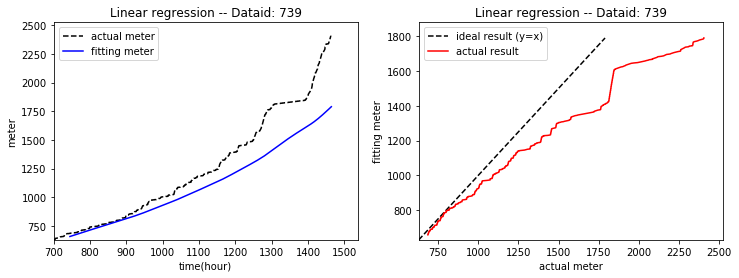

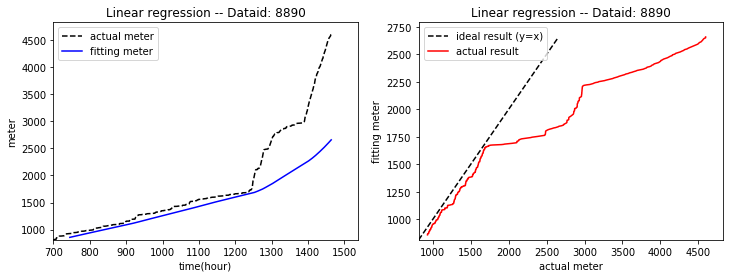

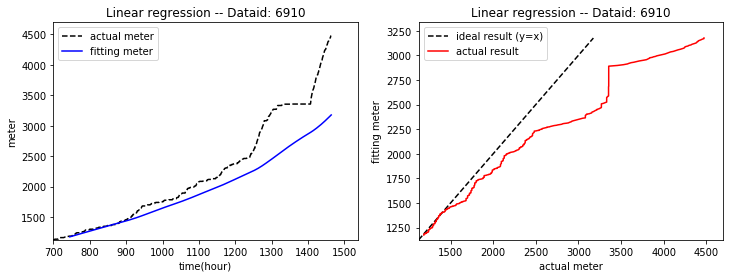

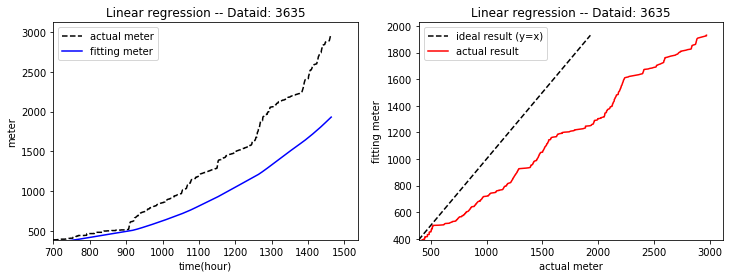

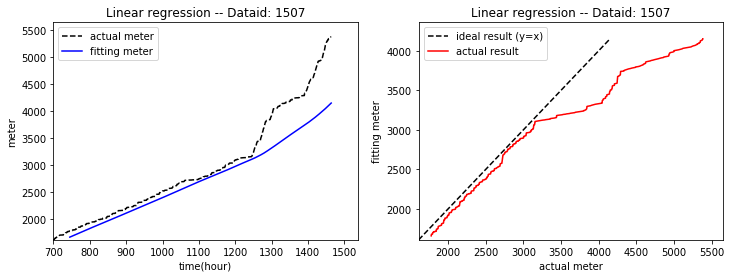

In [14]:
# Linear Regression
lr=lm.LinearRegression()
print('Linear regression:')
for i in range(k):
    if i+1>5:
        break
    h = np.arange(745,1465,1)
    y_lr = [0 for col in range(1465)]
    for j in h:
        x_tr = np.arange(0,j,1)
        lr.fit(x_tr[:,np.newaxis],hourly[i+1][0:j])
        y_lr[j]=lr.predict(hourly[0][:,np.newaxis])[j]
        
    print('Dataid: ',home_two.dataid.iloc[i])
    mse_prediction=mse(hourly[i+1][745:],y_lr[745:])
    print(f'Mean squared error on the predicted data: {mse_prediction:.2f}')
    
    plt.figure(i,figsize=(12,4))
    plt.subplot(121)
    plt.plot(hourly[0],hourly[i+1],'--k',label='actual meter')
    plt.plot(hourly[0][745:],y_lr[745:],'b',label='fitting meter')
    plt.xlabel('time(hour)')
    plt.ylabel('meter')
    plt.title('Linear regression -- Dataid: %s'%home_two.dataid.iloc[i])
    plt.xlim(700,)
    plt.ylim(hourly[i+1][700],)
    plt.legend(loc=2)
    plt.subplot(122)
    m = min(hourly[i+1][-1],y_lr[-1])
    mm = np.arange(0,m,1)
    plt.plot(mm,mm,'--k',label='ideal result (y=x)')
    plt.plot(hourly[i+1][745:],y_lr[745:],'r',label='actual result')
    plt.xlabel('actual meter')
    plt.ylabel('fitting meter')
    plt.title('Linear regression -- Dataid: %s'%home_two.dataid.iloc[i])
    plt.xlim(hourly[i+1][700],)
    plt.ylim(hourly[i+1][700],)
    plt.legend(loc=2)

**Analysis:**

Here we only show the November results, because the training data of October is always perfect fitted. From the left pictures, we can see that in this new model, the majority of the data can fit the model much better. But out of the irregularity of the actual data, it can be seen from the linear regression that the model trained by the very early data will affect the accuracy of the data prediction. 

**( 4 )** Model reoptimization

In order to make the accuracy of the prediction model can be improved flexibly, and also to save the time spent on building the model, we decided that the model used for each data is constructed from 100 pieces of data before the current time point.

Linear regression:
Dataid:  739
Mean squared error on the predicted data: 1630.29
Dataid:  8890
Mean squared error on the predicted data: 10786.99
Dataid:  6910
Mean squared error on the predicted data: 8500.43
Dataid:  3635
Mean squared error on the predicted data: 2482.63
Dataid:  1507
Mean squared error on the predicted data: 5670.81


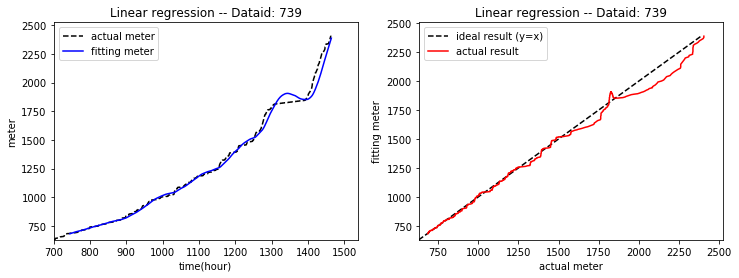

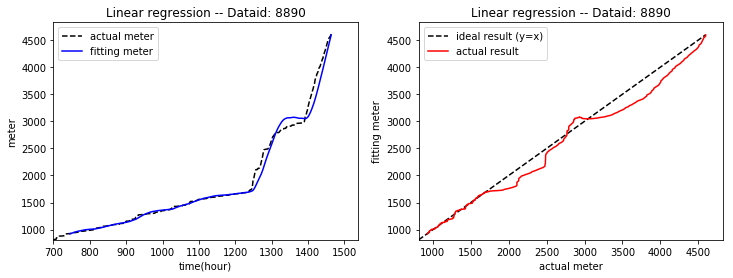

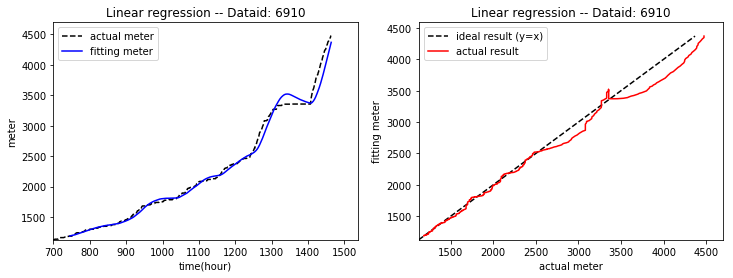

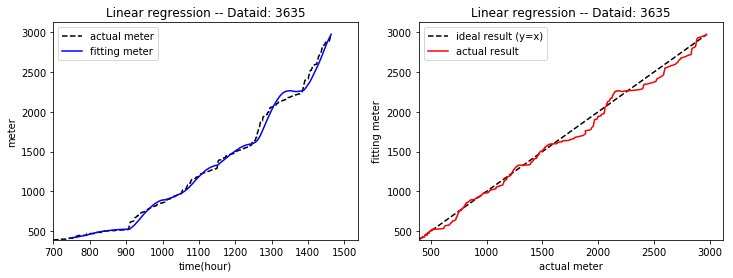

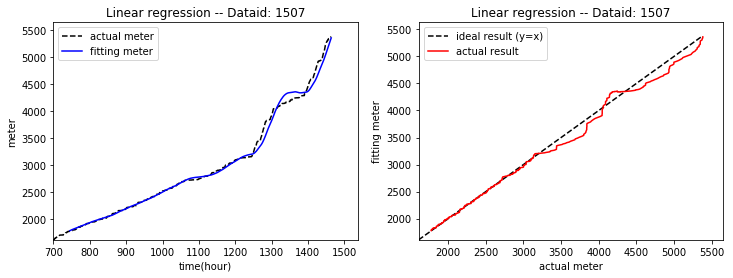

In [15]:
# Linear Regression
lr=lm.LinearRegression()
print('Linear regression:')
for i in range(k):
    if i+1>5:
        break
    h = np.arange(745,1465,1)
    y_lr = [0 for col in range(1465)]
    for j in h:
        x_tr = np.arange(j-100,j,1)
        lr.fit(x_tr[:,np.newaxis],hourly[i+1][j-100:j])
        y_lr[j]=lr.predict(hourly[0][:,np.newaxis])[j]
        
    print('Dataid: ',home_two.dataid.iloc[i])
    mse_prediction=mse(hourly[i+1][745:],y_lr[745:])
    print(f'Mean squared error on the predicted data: {mse_prediction:.2f}')
    
    plt.figure(i,figsize=(12,4))
    plt.subplot(121)
    plt.plot(hourly[0],hourly[i+1],'--k',label='actual meter')
    plt.plot(hourly[0][745:],y_lr[745:],'b',label='fitting meter')
    plt.xlabel('time(hour)')
    plt.ylabel('meter')
    plt.title('Linear regression -- Dataid: %s'%home_two.dataid.iloc[i])
    plt.xlim(700,)
    plt.ylim(hourly[i+1][700],)
    plt.legend(loc=2)
    plt.subplot(122)
    m = min(hourly[i+1][-1],y_lr[-1])
    mm = np.arange(0,m,1)
    plt.plot(mm,mm,'--k',label='ideal result (y=x)')
    plt.plot(hourly[i+1][745:],y_lr[745:],'r',label='actual result')
    plt.xlabel('actual meter')
    plt.ylabel('fitting meter')
    plt.title('Linear regression -- Dataid: %s'%home_two.dataid.iloc[i])
    plt.xlim(hourly[i+1][700],)
    plt.ylim(hourly[i+1][700],)
    plt.legend(loc=2)

SVR(linear):
Dataid:  739
Mean squared error on the predicted data: 2643.16
Dataid:  8890
Mean squared error on the predicted data: 17113.71
Dataid:  6910
Mean squared error on the predicted data: 14762.65
Dataid:  3635
Mean squared error on the predicted data: 3795.15
Dataid:  1507
Mean squared error on the predicted data: 7564.95


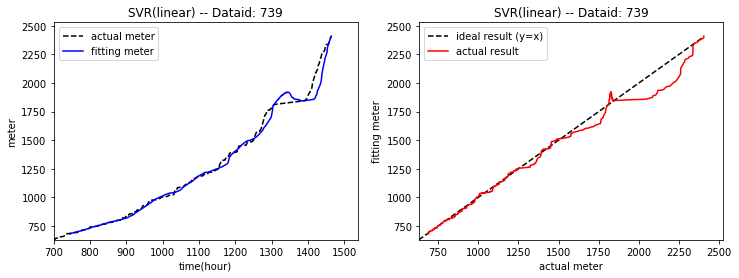

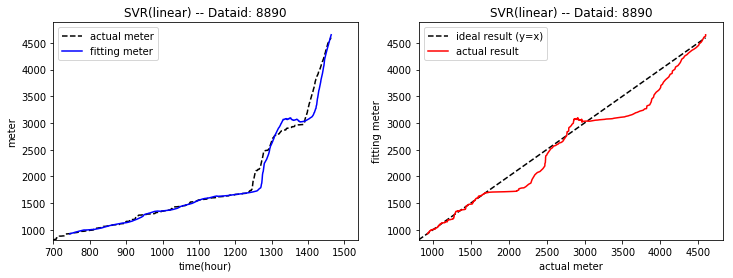

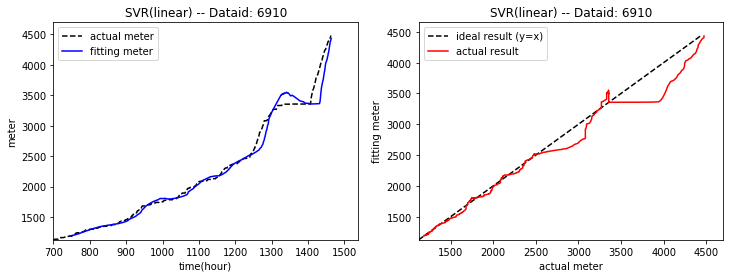

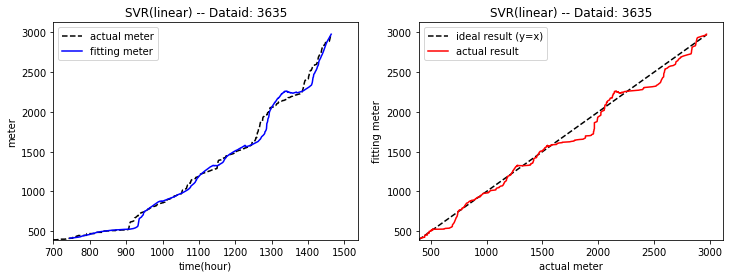

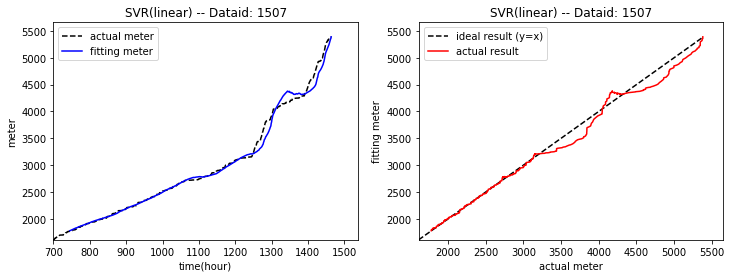

In [16]:
# SVR(linear)
lr = SVR(kernel="linear")
print('SVR(linear):')
for i in range(k):
    if i+1>5:
        break
    h = np.arange(745,1465,1)
    y_lr = [0 for col in range(1465)]
    for j in h:
        x_tr = np.arange(j-100,j,1)
        lr.fit(x_tr[:,np.newaxis],hourly[i+1][j-100:j])
        y_lr[j]=lr.predict(hourly[0][:,np.newaxis])[j]
        
    print('Dataid: ',home_two.dataid.iloc[i])
    mse_prediction=mse(hourly[i+1][745:],y_lr[745:])
    print(f'Mean squared error on the predicted data: {mse_prediction:.2f}')
    
    plt.figure(i,figsize=(12,4))
    plt.subplot(121)
    plt.plot(hourly[0],hourly[i+1],'--k',label='actual meter')
    plt.plot(hourly[0][745:],y_lr[745:],'b',label='fitting meter')
    plt.xlabel('time(hour)')
    plt.ylabel('meter')
    plt.title('SVR(linear) -- Dataid: %s'%home_two.dataid.iloc[i])
    plt.xlim(700,)
    plt.ylim(hourly[i+1][700],)
    plt.legend(loc=2)
    plt.subplot(122)
    m = min(hourly[i+1][-1],y_lr[-1])
    mm = np.arange(0,m,1)
    plt.plot(mm,mm,'--k',label='ideal result (y=x)')
    plt.plot(hourly[i+1][745:],y_lr[745:],'r',label='actual result')
    plt.xlabel('actual meter')
    plt.ylabel('fitting meter')
    plt.title('SVR(linear) -- Dataid: %s'%home_two.dataid.iloc[i])
    plt.xlim(hourly[i+1][700],)
    plt.ylim(hourly[i+1][700],)
    plt.legend(loc=2)

SVR(rbf):
Dataid:  739
Mean squared error on the predicted data: 1734.06
Dataid:  8890
Mean squared error on the predicted data: 49067.40
Dataid:  6910
Mean squared error on the predicted data: 18595.79
Dataid:  3635
Mean squared error on the predicted data: 5257.86
Dataid:  1507
Mean squared error on the predicted data: 21826.92


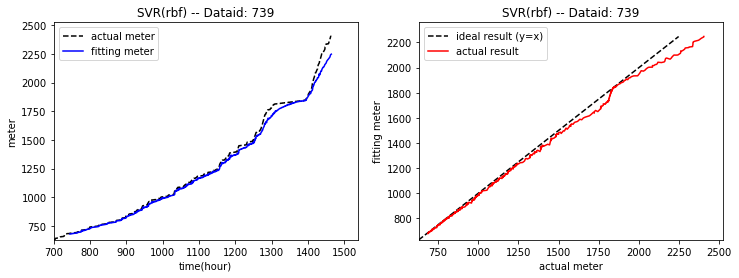

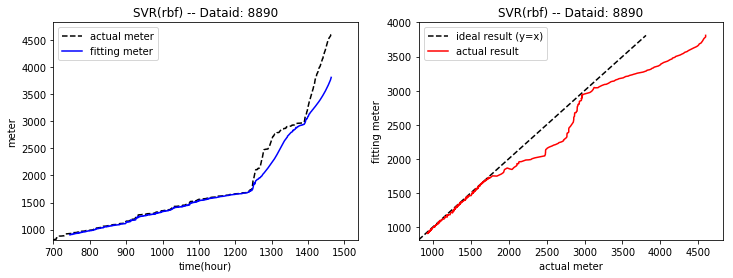

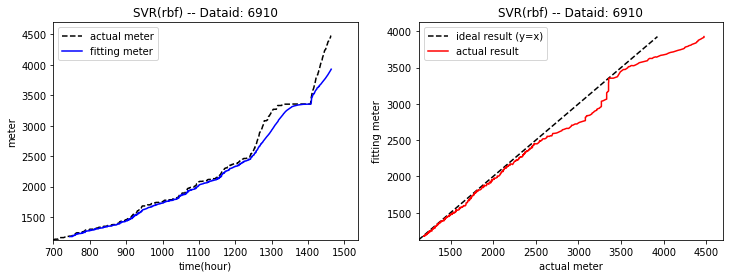

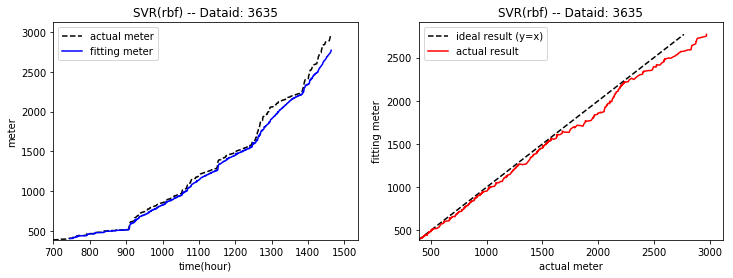

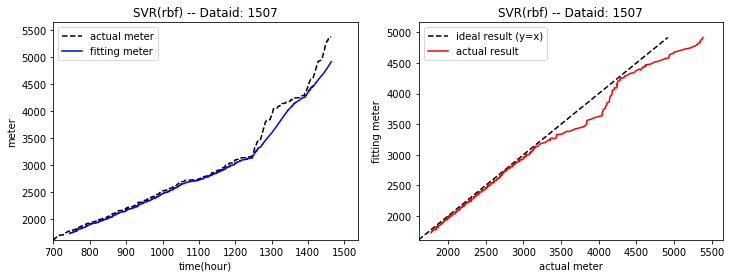

In [17]:
# SVR(rbf)
lr = SVR(kernel="rbf",C=100,gamma=0.1)
print('SVR(rbf):')
for i in range(k):
    if i+1>5:
        break
    h = np.arange(745,1465,1)
    y_lr = [0 for col in range(1465)]
    for j in h:
        x_tr = np.arange(j-100,j,1)
        lr.fit(x_tr[:,np.newaxis],hourly[i+1][j-100:j])
        y_lr[j]=lr.predict(hourly[0][:,np.newaxis])[j]
    
    print('Dataid: ',home_two.dataid.iloc[i])
    mse_prediction=mse(hourly[i+1][745:],y_lr[745:])
    print(f'Mean squared error on the predicted data: {mse_prediction:.2f}')
    
    plt.figure(i,figsize=(12,4))
    plt.subplot(121)
    plt.plot(hourly[0],hourly[i+1],'--k',label='actual meter')
    plt.plot(hourly[0][745:],y_lr[745:],'b',label='fitting meter')
    plt.xlabel('time(hour)')
    plt.ylabel('meter')
    plt.title('SVR(rbf) -- Dataid: %s'%home_two.dataid.iloc[i])
    plt.xlim(700,)
    plt.ylim(hourly[i+1][700],)
    plt.legend(loc=2)
    plt.subplot(122)
    m = min(hourly[i+1][-1],y_lr[-1])
    mm = np.arange(0,m,1)
    plt.plot(mm,mm,'--k',label='ideal result (y=x)')
    plt.plot(hourly[i+1][745:],y_lr[745:],'r',label='actual result')
    plt.xlabel('actual meter')
    plt.ylabel('fitting meter')
    plt.title('SVR(rbf) -- Dataid: %s'%home_two.dataid.iloc[i])
    plt.xlim(hourly[i+1][700],)
    plt.ylim(hourly[i+1][700],)
    plt.legend(loc=2)

**Summary:**

We still looking at the November only. After we improved the method of model building, the predicted results of all three models became significantly better. The mean square error of these three models was greatly reduced. And we found that if we use less former data when we perdict one point, we can get a better performance fitting line, because of the less influence will be done by the very early time point. In general, the linear regression was the most accurate prediction model, while SVR (linear) and SVR (rbf) have different performance while facing different data, so in this application, these two models are not as accurate and stable as linear regression.

<font size=4 >**Part 3: Proposal**</font>

As proposed in the interim, we plan to build an alarming system for natural gas consuming with the concerns of waste and danger. In this part, we firstly look into daily gas consumption for a couple of houses, aiming to find some common and unique properties of them. Then we select one house and analyze its hourly gas consumption in two months (October and November, 2015) in order to obtain hourly consumption characteristics. Finally, based on these analysis,  we can send reminder messages or set alarming thresholds.

**1.** Analyze daily gas consumption of 5 houses in two months.

Dataid:  739
        Thu. Fri. Sat. Sun. Mon. Tue. Wed.
Week 1:  18   10   30   28   20   22   18  
Week 2:  18   28   16   10   16   10   20  
Week 3:  20   24   22   36   28   24   18  
Week 4:  22   14   34   30    0   52   20  
Week 5:  22   26   30   14   26   22   20  
Week 6:  18   32   38   42   54   34   20  
Week 7:  36   50   56   38   32   26  106  
Week 8:  44   60   40  120  156   48    8  
Week 9:  10   10  192  222  144  

Dataid:  8890
        Thu. Fri. Sat. Sun. Mon. Tue. Wed.
Week 1:  42   14   16   50   18   22   12  
Week 2:  22   34   34   34   44   10   10  
Week 3:  24   22   32   42   16   24   30  
Week 4:  32   22   76   16    8   40   40  
Week 5:  24   72   46   28   28   44   36  
Week 6:  28   22   76   84   20   30   32  
Week 7:  72   22   72   38   32   16   26  
Week 8:  28   20  162  418  314  218  110  
Week 9:  56  110  578  508  442  

Dataid:  6910
        Thu. Fri. Sat. Sun. Mon. Tue. Wed.
Week 1:  28   36   34   82   30   20   22  
Week 2:  28 

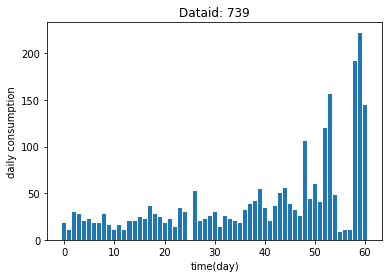

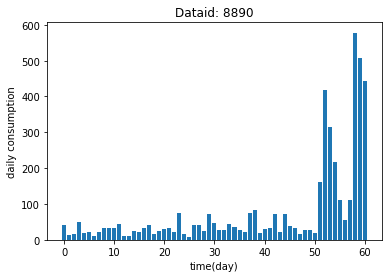

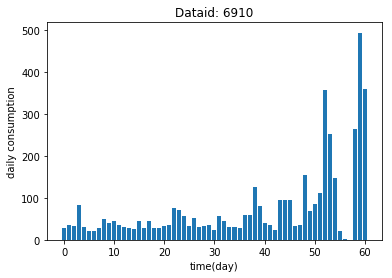

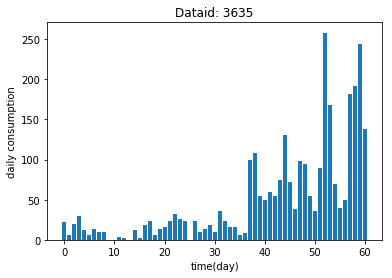

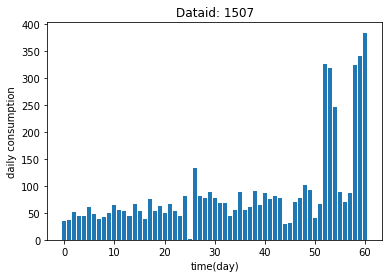

In [18]:
# For each one of the 5 selected house, 
# generate hourly readings in 2 months.
hourly_diff = [[0 for col in range(1464)] for row in range(home_two.shape[0])]
for i in range(k):
    for j in range(1464):
        hourly_diff[i][j]=hourly[i+1][j+1]-hourly[i+1][j]
        
# For each one of the 5 selected house, 
# generate daily readings in 2 months and plot.
for i in range(k):
    if i+1>5:
        break
    print('Dataid: ',home_two.dataid.iloc[i])
    daily_diff=[0 for col in range(61)]
    for j in range(61):
        daily_diff[j]=sum(hourly_diff[i][j*24:j*24+24])
    print("        Thu. Fri. Sat. Sun. Mon. Tue. Wed.")
    f=0
    while f+7<61:
        print("Week %d:"%(f/7+1),end=' ')
        [print("%3d"%ff,end='  ') for ff in daily_diff[f:f+7]]
        print()
        f+=7
    else:
        print("Week %d:"%(f/7+1),end=' ')
        [print("%3d"%ff,end='  ') for ff in daily_diff[f:]]
        print("\n")
    plt.figure(i)
    plt.bar(range(61),daily_diff)
    plt.title('Dataid: %s'%home_two.dataid.iloc[i])
    plt.xlabel('time(day)')
    plt.ylabel('daily consumption')

**Analysis:**

(1) As is shown above, totally there are 9 weeks or 61 days in October and November. For each house we create a table and a bar graph to show its daily consumption. The table can clearly display the change of daily consumption in every week.

(2) The above tables and figures show the daily changes for 5 selected houses in 2 months. Such information is valuable for both the gas supplier and the consumer. 

 - For the supplier, by looking into the general characteristics of most consumers, they can further explore the relationship between gas consumption and some causing factors such as weekend, holiday, temperature, weather and so on. For example, in cold season, the residents are very likely to consume more gas to warmer their house. Based on the temperature data and consumption data, the gas supplier can manage to quantify the relationship between temperature and consumption. In this way, the supplier can timely adjust their distributions in advance. 

 - For the consumers, they can derive a reminder of the costs in the previous day if they are interested. And they can also judge whether it's a good choice to use natural gas as their energy resource by comparing the costs between various resources. 

**2.** Analyze hourly gas consumption of one specific house in 2 months.

In [19]:
# Select one house(id = 739) and output its 24(hours)*61(days) values
for i in range(k):
    if i+1>1:
        break
    print('Dataid: ',home_two.dataid.iloc[i],'\n        ',end='')
    [print("%2d'"%ff,end='') for ff in range(1,25)]
    print()
    f=0
    while f+24<1464:
        print("Day %2d:"%(f/24+1),end=' ')
        [print("%2d"%ff,end=' ') for ff in hourly_diff[i][f:f+24]]
        print()
        f+=24
    else:
        print("Day %2d:"%(f/24+1),end=' ')
        [print("%2d"%ff,end=' ') for ff in hourly_diff[i][f:]]
        print()

Dataid:  739 
         1' 2' 3' 4' 5' 6' 7' 8' 9'10'11'12'13'14'15'16'17'18'19'20'21'22'23'24'
Day  1:  0  0  2  0  0  0  0  0  4  6  0  2  0  0  0  0  2  0  0  0  0  2  0  0 
Day  2:  0  0  2  0  0  0  0  2  0  2  0  0  0  0  0  2  0  0  0  0  2  0  0  0 
Day  3:  0  2  0  0  0  0  2  0 10  4  6  2  0  0  0  0  2  0  0  0  0  2  0  0 
Day  4:  0  2  0  0  0  0  0  2  0  2  0  8  2  0  0  0  0  2  2  0  0  6  0  2 
Day  5:  0  0  0  0  2  0  0  2  8  0  0  2  0  0  0  0  0  2  0  0  2  0  2  0 
Day  6:  0  0  0  0  2  0  0  8  2  0  0  0  0  0  2  0  0  0  0  2  2  4  0  0 
Day  7:  2  0  0  0  0  0  8  2  0  0  0  0  2  0  0  0  0  2  0  0  0  0  2  0 
Day  8:  0  0  0  2  0  0  0 10  0  0  0  0  2  0  0  0  0  0  2  0  0  0  0  2 
Day  9:  0  0  0  0  2  0  0  2  8  0  0  0  0  0  2  0  0  0  0  2  2  2  2  6 
Day 10:  0  0  0  0  0  2  0  2  6  0  2  0  0  0  0  0  2  0  0  0  0  2  0  0 
Day 11:  0  0  2  0  0  0  0  2  0  0  0  0  2  0  0  0  0  2  0  0  0  0  0  2 
Day 12:  0  0 

**Analysis:** 

(1) The above table shows *61 days * 24 hours* gas consumption of the house 739.

(2) For one thing, from the horizontal perspective we can get hourly values on a specific day. We can see there are some peak numbers horizontally, possibly implying that the family is using gas to cook during those hours. Therefore, we shouldn't set just one threshold for one day. Instead, multiple thresholds seem irrational. For another thing, from the vertical perspective we can get the values of a specific hour for several days. The numbers are not very stable as our expectation owing to some factors like holiday, weather and so on. This reminds us to set dynamic hourly threshold for the consumers so as to decrease the occurance of misinformation.

**3.** Dynamically set hourly consumption threshold.

In this part, we select one specific house (id=739) as representative. The implementaton for other houses is similar. As discussed above, it is irrational to set stable alarming threshold since unstability of gas consumption in a day and in the same hour of several days. Thus we manage to set dynamic thresholds which is the sum of the predicted value and a bias of 2. Note that the prediction is based on the linear regression model which has the smallest MSE, and the bias is chosen based on the analysis of consumer's hourly gas consumption in section 2.

Dataid:  739
Alarm! Level 1! (date:11-1, time:8'o clock)
Alarm! Level 2!! (date:11-1, time:9'o clock)
Alarm! Level 1! (date:11-1, time:21'o clock)
Alarm! Level 1! (date:11-2, time:8'o clock)
Alarm! Level 1! (date:11-2, time:24'o clock)
Alarm! Level 1! (date:11-3, time:9'o clock)
Alarm! Level 1! (date:11-4, time:7'o clock)
Alarm! Level 2!! (date:11-4, time:8'o clock)
Alarm! Level 1! (date:11-5, time:21'o clock)
Alarm! Level 1! (date:11-5, time:23'o clock)
Alarm! Level 1! (date:11-6, time:6'o clock)
Alarm! Level 1! (date:11-6, time:11'o clock)
Alarm! Level 1! (date:11-6, time:13'o clock)
Alarm! Level 2!! (date:11-6, time:14'o clock)
Alarm! Level 1! (date:11-6, time:19'o clock)
Alarm! Level 1! (date:11-7, time:9'o clock)
Alarm! Level 2!! (date:11-7, time:10'o clock)
Alarm! Level 1! (date:11-7, time:16'o clock)
Alarm! Level 2!! (date:11-7, time:17'o clock)
Alarm! Level 1! (date:11-7, time:21'o clock)
Alarm! Level 1! (date:11-8, time:7'o clock)
Alarm! Level 2!! (date:11-8, time:8'o clock)
A

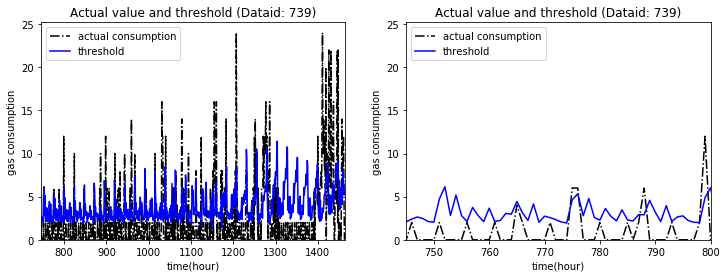

In [20]:
# Make prediction, set threshold and output alarming information.
lr=lm.LinearRegression()
temp=np.arange(0,1464,1)
his=30
level=1
for i in range(k):
    if i+1>1:
        break
    print('Dataid: ',home_two.dataid.iloc[i])
    h = np.arange(745,1464,1)
    y_lr = [0 for col in range(1464)]
    for j in h:
        x_tr = np.arange(j-24*his,j,24)
        lr.fit(x_tr[:,np.newaxis],hourly_diff[i][j-24*his:j:24])
        y_lr[j]=lr.predict(temp[:,np.newaxis])[j]+2
        if y_lr[j]<hourly_diff[i][j]:
            num+=1
            if level==1:
                print("Alarm! Level 1! (date:11-%d,"%(j//24-31),\
                      "time:%d'o clock)"%(j%24+1))
                level+=1
            elif level==2:
                print("Alarm! Level 2!! (date:11-%d,"%(j//24-31),\
                      "time:%d'o clock)"%(j%24+1))
                level+=1
            else:
                print("Alarm! Level 3!!! (date:11-%d,"%(j//24-31),\
                      "time:%d'o clock)"%(j%24+1))
        else:
            level=1
            
# Plot overall and partial actual consumption vs threshold.
    plt.figure(i,figsize=(12,4))
    plt.subplot(121)
    plt.plot(temp,hourly_diff[i],'-.k',label='actual consumption')
    plt.plot(temp[745:],y_lr[745:],'b',label='threshold')
    plt.xlabel('time(hour)')
    plt.ylabel('gas consumption')
    plt.title('Actual value and threshold (Dataid: %s)'%home_two.dataid.iloc[i])
    plt.xlim(745,1465)
    plt.ylim(0,)
    plt.legend(loc=2)
    plt.subplot(122)
    plt.plot(temp,hourly_diff[i],'-.k',label='actual consumption')
    plt.plot(temp[745:],y_lr[745:],'b',label='threshold')
    plt.xlabel('time(hour)')
    plt.ylabel('gas consumption')
    plt.title('Actual value and threshold (Dataid: %s)'%home_two.dataid.iloc[i])
    plt.xlim(745,800)
    plt.ylim(0,)
    plt.legend(loc=2)

**Analysis:** 

(1) The above table shows the alarming information in November of the house 739. And the two figures respectively show overall and partial actual consumption vs threshold.

(2) It can be seen that though we have given a bias of 2 in case of uncertainties, there are still too many cases when the actual consumption exceed the threshold and thus some alarming information is confusing or unwanted. To further explore these alarming information, we develop a **graduation alarming method**. To be specific, when the actual consumption exceed the threshold for the first time, the system give alarming signal marked as level 1. If such case happens again in the following hour, then the alarming signal will be marked as level 2. By that analogy, alarming signal which is marked as level 3 will be generated if three consecutive cases happen. Based on such a graduation method, the consumers can take personalized reaction to different level of alarm. For example, when level 3 alarm appear, it means the consumption is larger than expectation for a long period of time. This may indicate that there is something unusual happening. If the consumers are aware of the reason why it happens, then they can just ignore such an alarm. But if they feel confused. They can look for potential causes in time. In this way, consumers' losses can be minimized. Note that higher level doesn't consequentially mean higher seriousness. If consumers are confident that there isn't possible gas consumption while an level 1 alarm arises, this lower level alarm also deserves much attention. In conclusion, the graduation alarming method is just reference and support for consumers. In other word, it acts as a reminder of gas consumption and help the consumers take timely and rational action.